In [1]:
# Start loading libraries

#! pip install yfinance

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

#! pip install pmdarima
import pmdarima as pm
from pmdarima import model_selection

import scipy
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import PhillipsPerron
from arch.unitroot import KPSS

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
#from statsmodels.graphics.tsaplots import plot_acf

#from matplotlib.ticker import NullFormatter
#import yfinance as yf
#import warnings; warnings.simplefilter('ignore')
#%matplotlib inline

In [2]:
xls_file = pd.ExcelFile("Data_monthly_final.xlsx") # Read Excel
df1=xls_file.parse("FCPO") # Read the first sheet (Portfolio holdings)

#df1["Timestamp"] = df1["Date"].astype('datetime64[ns]') # Convert column to date format
df1 = df1.set_index(['Timestamp']) # use first column as index

#df1.to_excel("values.xlsx")  #print to excel


df1.describe()

,FCPOc1,FCPOc3,FCPOc6,FCPOc9,FCPOc12,MYR=,MYR3MV=,MYR6MV=,MYR9MV=,MYR1YV=,MYR1YNDFOR=,FCPOc1 USD,FCPOc3 USD,FCPOc6 USD,FCPOc9 USD,FCPOc12 USD
count,507.000000,506.000000,462.000000,387.000000,190.000000,507.000000,392.000000,392.000000,337.000000,375.000000,220.000000,507.000000,392.000000,392.000000,337.000000,375.000000
mean,1805.964497,1781.381423,1838.099567,2021.581395,2768.121053,3.250021,3.487300,3.523551,3.217639,3.535610,3.729375,539.169074,578.063262,564.944348,670.837715,379.219281
std,1071.874249,1021.147841,985.900508,936.214918,685.140360,0.675405,0.592425,0.548910,0.635356,0.587528,0.462950,258.906174,254.011060,246.249191,244.061359,398.023928
min,450.000000,448.000000,445.000000,768.000000,1620.000000,2.147000,2.434800,2.491200,2.664500,2.437000,2.986000,172.744722,198.587937,0.000000,0.000000,0.000000
25%,952.500000,943.750000,1002.250000,1241.000000,2367.500000,2.565500,3.060790,3.079750,2.776500,3.165750,3.307125,354.232570,371.918549,371.339232,507.706256,0.000000
50%,1455.000000,1443.500000,1515.500000,2050.000000,2543.000000,3.245000,3.659100,3.651700,2.817500,3.676800,3.690000,475.426279,538.159826,523.181643,607.327971,506.811232
75%,2405.000000,2416.000000,2455.750000,2544.500000,3029.000000,3.799750,3.813700,3.829200,3.968000,3.944500,4.180850,654.252357,709.699589,699.747068,808.629381,702.619061
max,7683.000000,7104.000000,6391.000000,6266.000000,6193.000000,4.726000,4.692000,4.662000,4.640000,4.710500,4.709500,1775.738799,1631.340850,1469.533226,1441.785550,1426.958525


<AxesSubplot:xlabel='Timestamp'>

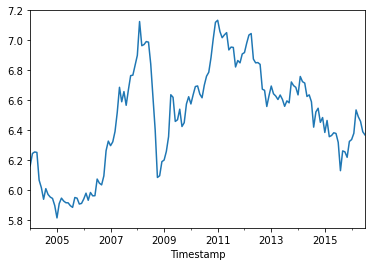

In [24]:
spot = df1["FCPOc1 USD"]
#spot = np.log(spot)
spot = spot.loc['2004-01-31':'2022-11-30']
spot_train = spot.loc[:'2016-07-31']
spot_train.plot()

In [25]:
#statistics

#mean
#sd
#skewness
#kurtosis
#jb test
#Ljung Box Q(6) and Q^2(6)
#observations

spot_train.describe()
#spot.dropna().describe()

count    151.000000
mean       6.486399
std        0.350372
min        5.815832
25%        6.249389
50%        6.547753
75%        6.719360
max        7.134813
Name: FCPOc1 USD, dtype: float64

In [26]:
print("Skewness spot:", scipy.stats.skew(spot_train.dropna(), axis=0, bias=True))
print("Skewness logs:", scipy.stats.skew(np.log(spot_train.dropna()), axis=0, bias=True))
print("Kurtosis spot:", scipy.stats.kurtosis(spot_train.dropna(), axis=0, fisher=False, bias=True))
print("Kurtosis logs:", scipy.stats.kurtosis(np.log(spot_train.dropna()), fisher=False, axis=0, bias=True))

print("JB spot:", scipy.stats.jarque_bera(spot_train.dropna()))
print("JB logs:", scipy.stats.jarque_bera(np.log(spot_train.dropna())))
#The Jarque-Bera Test is typically used for large datasets (n > 2000) in which other normality tests (like the Shapiro-Wilk test) are unreliable.

print("Q(6) spot:", sm.stats.acorr_ljungbox(spot_train.dropna(), lags=[6]))
print("Q(6) logs:", sm.stats.acorr_ljungbox(np.log(spot_train.dropna()), lags=[6]))

Skewness spot: -0.17006574375806946
Skewness logs: -0.2500808475104122
Kurtosis spot: 2.0283912472250507
Kurtosis logs: 2.0361906227188964
JB spot: Jarque_beraResult(statistic=6.667360941149747, pvalue=0.03566161172479254)
JB logs: Jarque_beraResult(statistic=7.418442740502711, pvalue=0.024496589621295306)
Q(6) spot:       lb_stat      lb_pvalue
6  692.458316  2.598921e-146
Q(6) logs:       lb_stat      lb_pvalue
6  698.713489  1.159547e-147


In [27]:
#stationarity

#augmented Dickie-Fuller
#PP test - Phillips and Perron
#KPSS

print("ADF spot:", adfuller(spot_train.dropna()))
print("ADF logs:", adfuller(np.log(spot_train.dropna())))

print("PP spot:", PhillipsPerron(spot_train.dropna()).summary().as_text())
print("PP logs:", PhillipsPerron(np.log(spot_train.dropna())).summary().as_text())



ADF spot: (-1.9717050963632765, 0.2991155382496726, 6, 144, {'1%': -3.476597917537401, '5%': -2.8818291230495543, '10%': -2.5775887982253085}, -276.5995759512085)
ADF logs: (-1.763873683183738, 0.3985390892987292, 1, 149, {'1%': -3.4750180242954167, '5%': -2.8811408028842043, '10%': -2.577221358046935}, -787.4985924826756)
PP spot:      Phillips-Perron Test (Z-tau)    
Test Statistic                 -1.831
P-value                         0.365
Lags                               14
-------------------------------------

Trend: Constant
Critical Values: -3.47 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
PP logs:      Phillips-Perron Test (Z-tau)    
Test Statistic                 -1.814
P-value                         0.374
Lags                               14
-------------------------------------

Trend: Constant
Critical Values: -3.47 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process

In [28]:

print("KPSS spot:", KPSS(spot_train.dropna()).summary().as_text())
print("KPSS logs:", KPSS(np.log(spot_train.dropna())).summary().as_text())

KPSS spot:     KPSS Stationarity Test Results   
Test Statistic                  0.668
P-value                         0.015
Lags                                8
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.
KPSS logs:     KPSS Stationarity Test Results   
Test Statistic                  0.686
P-value                         0.014
Lags                                8
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


ACF and PACF spot:
ACF and PACF logs:


c:\Users\tatuh\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
c:\Users\tatuh\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


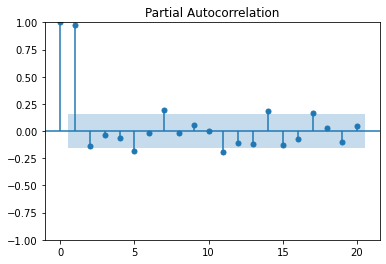

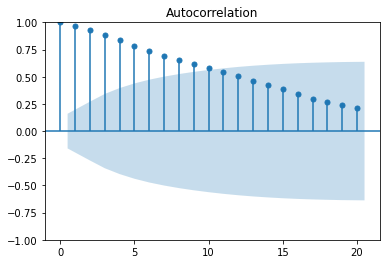

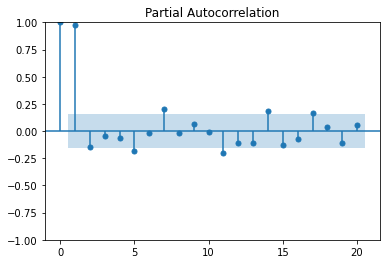

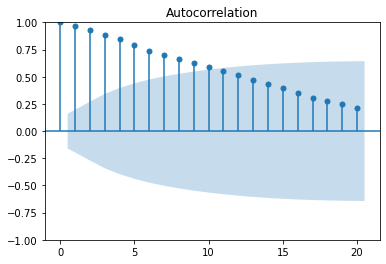

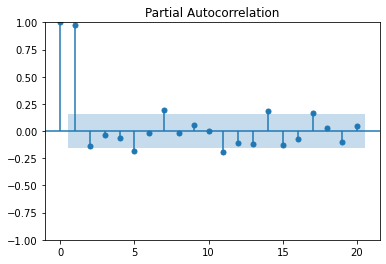

In [29]:
#ACF and PACF

print("ACF and PACF spot:")
plot_acf(spot_train.dropna(), lags = 20)
plot_pacf(spot_train.dropna(), lags = 20)


print("ACF and PACF logs:")
plot_acf(np.log(spot_train.dropna()), lags = 20)
plot_pacf(np.log(spot_train.dropna()), lags = 20)



0.6782943507735172

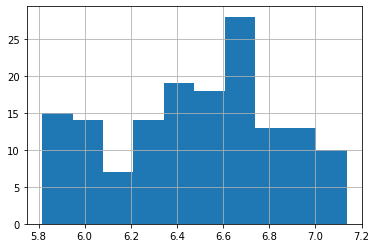

In [30]:
spot_train.hist()
0.6782943507735172

<AxesSubplot:>

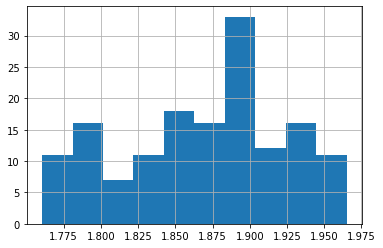

In [31]:
np.log(spot_train).hist()

In [32]:
# Load the data and split it into separate pieces
data = np.array(spot.dropna())
train, test = model_selection.train_test_split(data, train_size=(spot_train.shape[0]))
#train, test = model_selection.train_test_split(data, train_size=(spot.shape[0]-1))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-293.105, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-303.439, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-304.070, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-303.932, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-305.401, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-302.197, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.167 seconds


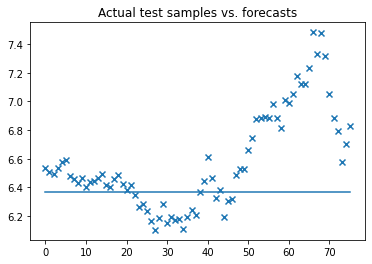

In [33]:
# Fit a simple auto_arima model
arima = pm.auto_arima(train, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=5,
                      seasonal=False)

#arima = pm.auto_arima(train, error_action='ignore', trace=True,
                      #suppress_warnings=True, maxiter=5,
                      #seasonal=True, m=12)

# #############################################################################
# Plot actual test vs. forecasts:
x = np.arange(test.shape[0])
plt.scatter(x, test, marker='x')
plt.plot(x, arima.predict(n_periods=test.shape[0]))
plt.title('Actual test samples vs. forecasts')
plt.show()

In [34]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  151
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 153.701
Date:                Sat, 07 Jan 2023   AIC                           -305.401
Time:                        14:17:03   BIC                           -302.391
Sample:                             0   HQIC                          -304.178
                                - 151                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0075      0.001     11.177      0.000       0.006       0.009
===================================================================================
Ljung-Box (L1) (Q):                   2.66   Jarque-Bera (JB):                14.68
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                            -0.36
Prob(H) (two-sided):                  0.73   Kurtosis:                         4.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

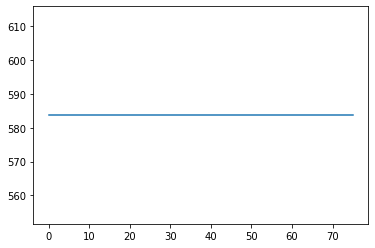

In [18]:
plt.plot(x, arima.predict(n_periods=test.shape[0]))

In [19]:
arima.predict(n_periods=test.shape[0])

array([583.72264568, 583.72264568, 583.72264568, 583.72264568,
       583.72264568, 583.72264568, 583.72264568, 583.72264568,
       583.72264568, 583.72264568, 583.72264568, 583.72264568,
       583.72264568, 583.72264568, 583.72264568, 583.72264568,
       583.72264568, 583.72264568, 583.72264568, 583.72264568,
       583.72264568, 583.72264568, 583.72264568, 583.72264568,
       583.72264568, 583.72264568, 583.72264568, 583.72264568,
       583.72264568, 583.72264568, 583.72264568, 583.72264568,
       583.72264568, 583.72264568, 583.72264568, 583.72264568,
       583.72264568, 583.72264568, 583.72264568, 583.72264568,
       583.72264568, 583.72264568, 583.72264568, 583.72264568,
       583.72264568, 583.72264568, 583.72264568, 583.72264568,
       583.72264568, 583.72264568, 583.72264568, 583.72264568,
       583.72264568, 583.72264568, 583.72264568, 583.72264568,
       583.72264568, 583.72264568, 583.72264568, 583.72264568,
       583.72264568, 583.72264568, 583.72264568, 583.72

<AxesSubplot:xlabel='Timestamp'>

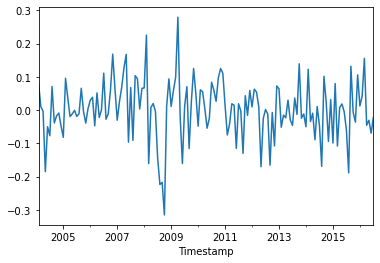

In [21]:
spot2 = np.log(spot).diff()
#spot2 = spot.diff()
spot_train2 = spot2.loc[:'2016-07-31'].dropna()
spot_train2.plot()


In [22]:
#statistics

#mean
#sd
#skewness
#kurtosis
#jb test
#Ljung Box Q(6) and Q^2(6)
#observations

spot_train2.describe()
#spot.dropna().describe()

count    150.000000
mean       0.001370
std        0.087127
min       -0.315505
25%       -0.039074
50%        0.002619
75%        0.059761
max        0.279404
Name: FCPOc1 USD, dtype: float64

In [23]:
print("Skewness spot:", scipy.stats.skew(spot_train2.dropna(), axis=0, bias=True))
#print("Skewness logs:", scipy.stats.skew(np.log(spot2.dropna()), axis=0, bias=True))
print("Kurtosis spot:", scipy.stats.kurtosis(spot_train2.dropna(), axis=0, fisher=False, bias=True))
#print("Kurtosis logs:", scipy.stats.kurtosis(np.log(spot2.dropna()), fisher=False, axis=0, bias=True))

print("JB spot:", scipy.stats.jarque_bera(spot_train2.dropna()))
#print("JB logs:", scipy.stats.jarque_bera(np.log(spot2.dropna())))
#The Jarque-Bera Test is typically used for large datasets (n > 2000) in which other normality tests (like the Shapiro-Wilk test) are unreliable.

print("Q(6) spot:", sm.stats.acorr_ljungbox(spot_train2.dropna(), lags=[6]))
#print("Q(6) logs:", sm.stats.acorr_ljungbox(np.log(spot2.dropna()), lags=[6]))

Skewness spot: -0.35808790742773494
Kurtosis spot: 4.354676462793729
JB spot: Jarque_beraResult(statistic=14.675350728945148, pvalue=0.0006505610819158569)
Q(6) spot:      lb_stat  lb_pvalue
6  11.496558    0.07419


In [24]:
#stationarity

#augmented Dickie-Fuller
#PP test - Phillips and Perron
#KPSS

print("ADF spot:", adfuller(spot_train2.dropna()))
#print("ADF logs:", adfuller(np.log(spot2.dropna())))

print("PP spot:", PhillipsPerron(spot_train2.dropna()).summary().as_text())
#print("PP logs:", PhillipsPerron(np.log(spot2.dropna())).summary().as_text())

ADF spot: (-5.651991325855623, 9.812575147996136e-07, 5, 144, {'1%': -3.476597917537401, '5%': -2.8818291230495543, '10%': -2.5775887982253085}, -271.34567735175784)
PP spot:      Phillips-Perron Test (Z-tau)    
Test Statistic                -10.599
P-value                         0.000
Lags                               14
-------------------------------------

Trend: Constant
Critical Values: -3.48 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [25]:
print("KPSS spot:", KPSS(spot_train2.dropna()).summary().as_text())
#print("KPSS logs:", KPSS(np.log(spot2.dropna())).summary().as_text())

KPSS spot:     KPSS Stationarity Test Results   
Test Statistic                  0.110
P-value                         0.541
Lags                                3
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


ACF and PACF spot:


c:\Users\tatuh\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


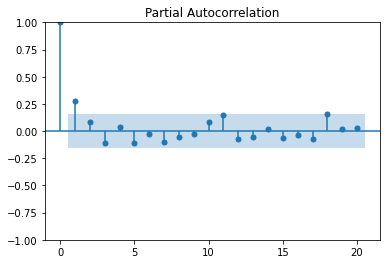

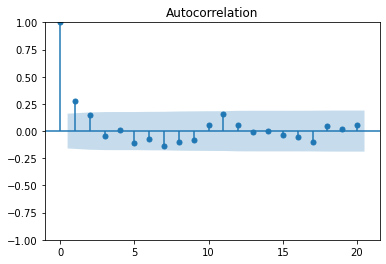

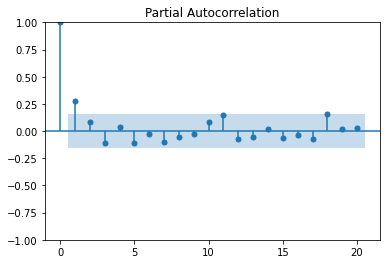

In [26]:
#ACF and PACF

print("ACF and PACF spot:")
plot_acf(spot_train2.dropna(), lags = 20)
plot_pacf(spot_train2.dropna(), lags = 20)


#print("ACF and PACF logs:")
#plot_acf(np.log(spot2.dropna()), lags = 15)
#plot_pacf(np.log(spot2.dropna()), lags = 15)


<AxesSubplot:>

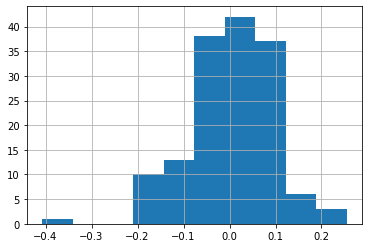

In [27]:
spot_train2.hist()


In [28]:
# Load the data and split it into separate pieces
data2 = np.array(spot2.dropna())
train2, test2 = model_selection.train_test_split(data2, train_size=(spot_train2.shape[0]))

In [29]:
train2

array([ 9.94141527e-02, -2.25927401e-02,  9.00744900e-02,  5.91221972e-02,
       -5.85423189e-02,  1.48669849e-01, -1.05475614e-02,  1.57786720e-01,
        5.45437197e-02, -7.34799695e-02, -1.17618250e-01,  1.26586920e-01,
        8.63215340e-02,  8.11177619e-02, -6.07512646e-02, -7.07133176e-03,
        9.13059727e-02,  6.59656240e-02,  1.21202034e-01, -5.42661867e-02,
       -8.85592318e-02, -5.39238007e-02,  6.89565402e-02,  1.12304812e-01,
       -6.62473097e-02,  6.50342693e-02,  9.52963868e-02, -2.92512633e-02,
        4.30861529e-02,  2.20646648e-02, -6.74258080e-02, -1.17213803e-01,
       -5.68007163e-02,  8.48915644e-02, -5.43612092e-02, -5.85318411e-02,
        7.53143124e-02,  9.56185974e-02, -6.62985854e-03,  5.74841291e-03,
        4.83421480e-02,  7.60166462e-02, -5.82507383e-02,  8.53936157e-02,
        1.35187845e-01, -2.64982802e-02,  6.14107592e-02, -1.76291785e-02,
        8.21011018e-02,  1.99600865e-03,  1.04602502e-01,  1.37541839e-01,
        9.01173639e-02, -

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-296.359, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-288.825, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-298.902, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-296.306, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-297.814, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-297.394, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-287.640, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-296.957, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.239 seconds


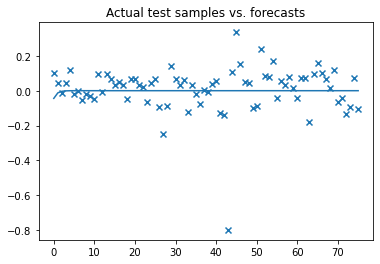

In [30]:
# Fit a simple auto_arima model
arima2 = pm.auto_arima(train2, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=5,
                      seasonal=False)

#arima = pm.auto_arima(train, error_action='ignore', trace=True,
                      #suppress_warnings=True, maxiter=5,
                      #seasonal=True, m=12)

# #############################################################################
# Plot actual test vs. forecasts:
x2 = np.arange(test2.shape[0])
plt.scatter(x2, test2, marker='x')
plt.plot(x2, arima2.predict(n_periods=test2.shape[0]))
plt.title('Actual test samples vs. forecasts')
plt.show()

In [31]:
arima2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  150
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 151.451
Date:                Sat, 31 Dec 2022   AIC                           -298.902
Time:                        08:55:51   BIC                           -292.881
Sample:                             0   HQIC                          -296.456
                                - 150                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2807      0.075      3.757      0.000       0.134       0.427
sigma2         0.0078      0.001     10.617      0.000       0.006       0.009
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                14.59
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               1.22   Skew:                            -0.37
Prob(H) (two-sided):                  0.49   Kurtosis:                         4.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

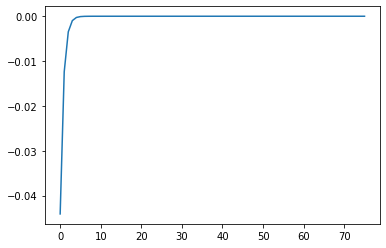

In [32]:
plt.plot(x2, arima2.predict(n_periods=test2.shape[0]))

In [33]:
tests = arima2.predict(n_periods=test2.shape[0])
tests

array([-4.40798827e-02, -1.23728750e-02, -3.47296832e-03, -9.74834783e-04,
       -2.73628426e-04, -7.68053385e-05, -2.15586520e-05, -6.05134339e-06,
       -1.69856431e-06, -4.76773589e-07, -1.33826582e-07, -3.75640647e-08,
       -1.05439363e-08, -2.95959967e-09, -8.30736259e-10, -2.33181108e-10,
       -6.54520958e-11, -1.83718864e-11, -5.15684346e-12, -1.44748524e-12,
       -4.06297677e-13, -1.14044550e-13, -3.20114045e-14, -8.98534848e-15,
       -2.52211637e-15, -7.07938149e-16, -1.98712648e-16, -5.57770713e-17,
       -1.56561835e-17, -4.39456707e-18, -1.23352028e-18, -3.46239401e-19,
       -9.71866660e-20, -2.72795297e-20, -7.65714859e-21, -2.14930114e-21,
       -6.03291860e-22, -1.69339261e-22, -4.75321935e-23, -1.33419114e-23,
       -3.74496917e-24, -1.05118328e-24, -2.95058845e-25, -8.28206879e-26,
       -2.32471131e-26, -6.52528108e-27, -1.83159487e-27, -5.14114218e-28,
       -1.44307802e-28, -4.05060604e-29, -1.13697313e-29, -3.19139380e-30,
       -8.95799039e-31, -

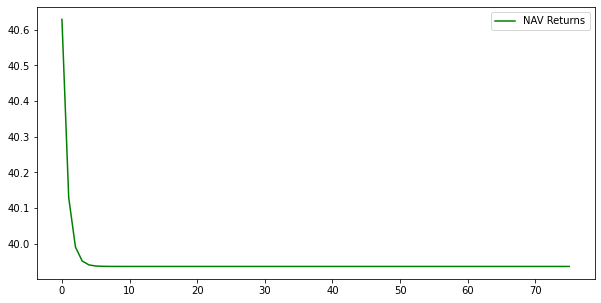

In [34]:
cum_res = np.exp(tests.cumsum())*spot.iloc[spot_train.shape[0]-1]
#cum_res = tests.cumsum()+spot.iloc[spot_train.shape[0]-1]
plt.figure(figsize=(10,5))
plt.plot(cum_res, color='g',label = 'NAV Returns')
plt.legend()
plt.show()

In [35]:
cum_res

array([40.62901935, 40.12941869, 39.99029222, 39.95132729, 39.94039697,
       39.93732945, 39.93646846, 39.93622679, 39.93615896, 39.93613992,
       39.93613458, 39.93613307, 39.93613265, 39.93613254, 39.9361325 ,
       39.93613249, 39.93613249, 39.93613249, 39.93613249, 39.93613249,
       39.93613249, 39.93613249, 39.93613249, 39.93613249, 39.93613249,
       39.93613249, 39.93613249, 39.93613249, 39.93613249, 39.93613249,
       39.93613249, 39.93613249, 39.93613249, 39.93613249, 39.93613249,
       39.93613249, 39.93613249, 39.93613249, 39.93613249, 39.93613249,
       39.93613249, 39.93613249, 39.93613249, 39.93613249, 39.93613249,
       39.93613249, 39.93613249, 39.93613249, 39.93613249, 39.93613249,
       39.93613249, 39.93613249, 39.93613249, 39.93613249, 39.93613249,
       39.93613249, 39.93613249, 39.93613249, 39.93613249, 39.93613249,
       39.93613249, 39.93613249, 39.93613249, 39.93613249, 39.93613249,
       39.93613249, 39.93613249, 39.93613249, 39.93613249, 39.93

In [36]:
#cointegration tests

#normalized cv
#LR test

In [37]:
#correlaatiomatriisi

In [38]:
#np.argwhere(np.isnan(x))